In [ ]:
from google.colab import drive
from glob import glob
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, MaxPool2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations as A

In [ ]:
drive.mount('/content/drive')
ROOT = '/content/drive/MyDrive/'
IMAGE_SIZE = (256, 256)

# Number of epochs
EPOCHS = 40

# Batch size
BATCH_SIZE = 32

data_dir = ROOT+'archive/lgg-mri-segmentation/kaggle_3m'

Mounted at /content/drive


In [ ]:
images_paths = []
masks_paths = glob(f'{data_dir}/*/*_mask*')

for mask_path in masks_paths:
    image_path = mask_path.replace('_mask', '')
    images_paths.append(image_path)

df = pd.DataFrame(data={'images_paths': images_paths, 'masks_paths': masks_paths})

In [ ]:
train_df, other_df = train_test_split(df, test_size=0.9, random_state=42)
unlabeled_df, val_df = train_test_split(other_df, test_size=0.1, random_state=42)
print(len(train_df), len(unlabeled_df), len(val_df))

392 3183 354


In [ ]:
def decode_and_resize_image(img_path):
    # Open the image using PIL
    with tf.io.gfile.GFile(img_path, 'rb') as f:
        img = Image.open(f)
        img = img.convert('RGB')  # Ensure the image is in RGB format
        img = img.resize(IMAGE_SIZE, Image.ANTIALIAS)  # Resize the image

    # Convert the image to a numpy array and normalize it
    img = np.array(img) / 255.0  # Normalize the image to the range [0, 1]

    # Convert the numpy array to a TensorFlow tensor
    img = tf.convert_to_tensor(img, dtype=tf.float32)

    return img
def decode_and_resize_mask(mask_path):
    # Open the mask using PIL
    with tf.io.gfile.GFile(mask_path, 'rb') as f:
        mask = Image.open(f)
        mask = mask.convert('L')  # Ensure the mask is in grayscale format
        mask = mask.resize(IMAGE_SIZE, Image.NEAREST)  # Resize the mask using nearest neighbor

    # Convert the mask to a numpy array and normalize it
    mask = np.array(mask) / 255.0  # Normalize the mask to the range [0, 1]
    mask = np.expand_dims(mask, axis=-1)  # Add a channel dimension

    # Convert the numpy array to a TensorFlow tensor
    mask = tf.convert_to_tensor(mask, dtype=tf.float32)

    return mask

In [ ]:
def processed_input(img, mask):

    return img, mask

# Prepares the dataset
def make_dataset(images, masks):
    dataset = tf.data.Dataset.from_tensor_slices((list(map(lambda x: decode_and_resize_image(x), images)),
                                                 list(map(lambda x: decode_and_resize_mask(x), masks))))
    # Shuffle dataset
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    # Map dataset
    dataset = dataset.map(processed_input, num_parallel_calls=tf.data.AUTOTUNE)
    # While the current batch of data is being processed, prefetching the next batch based on available resources.
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
train_dataset = make_dataset(list(train_df['images_paths'].values), list(train_df['masks_paths'].values))
validation_dataset = make_dataset(list(val_df['images_paths'].values), list(val_df['masks_paths'].values))

<ipython-input-5-b7bfb1c12be3>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(IMAGE_SIZE, Image.ANTIALIAS)  # Resize the image


In [ ]:
# Convolutional block
def conv_block(inputs, n_filters, kernel_initializer=HeNormal(), use_bias=False, max_pool=True):
    x = Conv2D(n_filters, 3, padding='same', kernel_initializer=kernel_initializer, use_bias=use_bias)(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(n_filters, 3, padding='same', kernel_initializer=kernel_initializer, use_bias=use_bias)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    skip = x
    if max_pool:
        next_layer = MaxPool2D()(x)
    else:
        next_layer = x
    return next_layer, skip

# Upsampling block
def up_block(reg_inputs, skip_inputs, n_filters, kernel_initializer=HeNormal(), use_bias=False):
    x = Conv2DTranspose(n_filters, 3, strides=2, padding='same', kernel_initializer=kernel_initializer, use_bias=use_bias)(reg_inputs)
    x = concatenate([x, skip_inputs], axis=3)
    x = conv_block(x, n_filters, kernel_initializer=kernel_initializer, use_bias=use_bias, max_pool=False)[0]
    return x

# U-Net model
def unet(input_size=(256, 256, 3)):
    # Encoder block
    inputs = Input(shape=input_size, name='Input')
    cb1, cb1_skip = conv_block(inputs, 32)
    cb2, cb2_skip = conv_block(cb1, 64)
    cb3, cb3_skip = conv_block(cb2, 128)
    cb4, cb4_skip = conv_block(cb3, 256)
    cb5, _ = conv_block(cb4, 512, max_pool=False)

    # Decoder block
    up1 = up_block(cb5, cb4_skip, 256)
    up2 = up_block(up1, cb3_skip, 128)
    up3 = up_block(up2, cb2_skip, 64)
    up4 = up_block(up3, cb1_skip, 32)

    # Output
    conv1 = Conv2D(32, 3, padding='same', kernel_initializer=HeNormal(), use_bias=False)(up4)
    bn = BatchNormalization()(conv1)
    act = LeakyReLU(0.2)(bn)
    outputs = Conv2D(1, 1, padding='same', activation='sigmoid', name='Output')(act)

    # Creating the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compiling the model
    model.compile(optimizer=Adam(3e-4), loss='mean_squared_error')

    return model

In [ ]:
model = unet()
# Define the path to save the best weights
checkpoint_path = ROOT+"archive/best_model_no_augmentation.h5"

# Define ModelCheckpoint callback to save the best weights
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                    monitor='val_loss',
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1)

# Define EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss',
                patience=6,
                restore_best_weights=True)

# Train the model
history_1 = model.fit(train_dataset,
          validation_data=validation_dataset,
          epochs=EPOCHS,
          callbacks=[early_stopping, checkpoint_callback])

Epoch 1/40
13/13 [==============================] - ETA: 0s - loss: 0.2106
Epoch 1: val_loss improved from inf to 0.96958, saving model to /content/drive/MyDrive/archive/best_model_no_augmentation.h5
13/13 [==============================] - 21s 1s/step - loss: 0.2106 - val_loss: 0.9696
Epoch 2/40
13/13 [==============================] - ETA: 0s - loss: 0.1118
Epoch 2: val_loss improved from 0.96958 to 0.93937, saving model to /content/drive/MyDrive/archive/best_model_no_augmentation.h5
13/13 [==============================] - 13s 994ms/step - loss: 0.1118 - val_loss: 0.9394
Epoch 3/40
13/13 [==============================] - ETA: 0s - loss: 0.0712
Epoch 3: val_loss did not improve from 0.93937
13/13 [==============================] - 15s 1s/step - loss: 0.0712 - val_loss: 0.9738
Epoch 4/40
13/13 [==============================] - ETA: 0s - loss: 0.0554
Epoch 4: val_loss improved from 0.93937 to 0.79916, saving model to /content/drive/MyDrive/archive/best_model_no_augmentation.h5
13/13 

In [ ]:
import plotly.graph_objects as go

def plot_history(history):
    # Create the plot
    fig = go.Figure()

    # Add training loss trace
    fig.add_trace(go.Scatter(
        x=list(range(1, len(history.history['loss']) + 1)),
        y=history.history['loss'],
        mode='lines+markers',
        name='Training Loss',
        marker=dict(color='blue')
    ))

    # Add validation loss trace
    fig.add_trace(go.Scatter(
        x=list(range(1, len(history.history['val_loss']) + 1)),
        y=history.history['val_loss'],
        mode='lines+markers',
        name='Validation Loss',
        marker=dict(color='red')
    ))

    # Update layout
    fig.update_layout(
        title="Training vs Validation Loss",
        xaxis_title="Epoch",
        yaxis_title="Loss",
        legend=dict(x=0.5, y=1.1, orientation='h', xanchor='center')
    )

    # Show the plot
    fig.show()


In [ ]:
plot_history(history_1)

In [ ]:
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ElasticTransform(p=0.1, alpha=0.2, sigma=10, alpha_affine=5),
    A.RandomBrightnessContrast(p=0.2, brightness_limit=0.1, contrast_limit=0.1),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.01, rotate_limit=5, p=0.2),
    A.GaussianBlur(p=0.1, blur_limit=(3, 7)),
    A.GridDistortion(p=0.1),
    A.CoarseDropout(p=0.1, max_holes=8, max_height=16, max_width=16, min_holes=4, min_height=8, min_width=8)
])

In [ ]:
def apply_augmentation(img, mask):
    augmented = augmentation_pipeline(image=img.numpy(), mask=mask.numpy())
    img_aug = tf.convert_to_tensor(augmented['image'], dtype=tf.float32)
    mask_aug = tf.convert_to_tensor(augmented['mask'], dtype=tf.float32)
    return img_aug, mask_aug

In [ ]:
def make_dataset_augmentation(images, masks):
    dataset = tf.data.Dataset.from_tensor_slices((list(map(lambda x: decode_and_resize_image(x), images)),
                                                 list(map(lambda x: decode_and_resize_mask(x), masks))))

    def apply_augmentation_wrapper(img, mask):
        img_aug, mask_aug = tf.py_function(apply_augmentation, [img, mask], [tf.float32, tf.float32])
        img_aug.set_shape(img.shape)
        mask_aug.set_shape(mask.shape)
        return img_aug, mask_aug

    dataset = dataset.map(apply_augmentation_wrapper, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [ ]:
train_dataset = make_dataset_augmentation(list(train_df['images_paths'].values), list(train_df['masks_paths'].values))

<ipython-input-5-b7bfb1c12be3>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(IMAGE_SIZE, Image.ANTIALIAS)  # Resize the image


In [ ]:
model = unet()

# Define the path to save the best weights
checkpoint_path = ROOT + "archive/best_model_with_augmentation.h5"

# Define ModelCheckpoint callback to save the best weights
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                    monitor='val_loss',
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1)

# Define EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss',
                patience=6,
                restore_best_weights=True)

# Train the model
history_2 = model.fit(train_dataset,
          validation_data=validation_dataset,
          epochs=EPOCHS,
          callbacks=[early_stopping, checkpoint_callback])

Epoch 1/40
13/13 [==============================] - ETA: 0s - loss: 0.2651
Epoch 1: val_loss improved from inf to 0.89689, saving model to /content/drive/MyDrive/archive/best_model_with_augmentation.h5
13/13 [==============================] - 19s 673ms/step - loss: 0.2651 - val_loss: 0.8969
Epoch 2/40
13/13 [==============================] - ETA: 0s - loss: 0.1236
Epoch 2: val_loss did not improve from 0.89689
13/13 [==============================] - 8s 561ms/step - loss: 0.1236 - val_loss: 0.9555
Epoch 3/40
13/13 [==============================] - ETA: 0s - loss: 0.0797
Epoch 3: val_loss did not improve from 0.89689
13/13 [==============================] - 9s 570ms/step - loss: 0.0797 - val_loss: 0.9805
Epoch 4/40
13/13 [==============================] - ETA: 0s - loss: 0.0651
Epoch 4: val_loss did not improve from 0.89689
13/13 [==============================] - 9s 578ms/step - loss: 0.0651 - val_loss: 0.9363
Epoch 5/40
13/13 [==============================] - ETA: 0s - loss: 0.0581


In [ ]:
plot_history(history_2)

In [ ]:
cd ./drive/MyDrive/archive/RabbaniSeg/for_redistribution_files_only

/content/drive/MyDrive/archive/RabbaniSeg/for_redistribution_files_only


In [ ]:
!wget -q -O MATLAB_Runtime_R2024a_Update_5_glnxa64.zip https://ssd.mathworks.com/supportfiles/downloads/R2024a/Release/5/deployment_files/installer/complete/glnxa64/MATLAB_Runtime_R2024a_Update_5_glnxa64.zip
!unzip -q MATLAB_Runtime_R2024a_Update_5_glnxa64.zip -d /content/mcr_install

!chmod +x /content/mcr_install/install
!/content/mcr_install/install -destinationFolder /usr/local/MATLAB/MATLAB_Runtime/v97 -mode silent -agreeToLicense yes > install_log.txt 2>&1

In [ ]:
os.environ['LD_LIBRARY_PATH'] = '/usr/local/MATLAB/MATLAB_Runtime/v97/R2024a/runtime/glnxa64:/usr/local/MATLAB/MATLAB_Runtime/v97/R2024a/bin/glnxa64:/usr/local/MATLAB/MATLAB_Runtime/v97/R2024a/sys/os/glnxa64:' + os.environ.get('LD_LIBRARY_PATH', '')


In [ ]:
import subprocess
result = subprocess.run(['python', './setup.py', 'install'], capture_output=True, text=True)

In [ ]:
import RabbaniSeg

In [ ]:
print(dir(RabbaniSeg))

['_PathInitializer', '__builtins__', '__cached__', '__doc__', '__exit_packages', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_pir', 'atexit', 'glob', 'importlib', 'initialize', 'initialize_runtime', 'os', 'pdb', 'platform', 're', 'sys', 'terminate_runtime', 'weakref']


In [ ]:
import cv2
target_folder = ROOT + 'archive/recon_folder'
if not os.path.exists(target_folder):
    os.makedirs(target_folder)
for index, row in train_df.iterrows():
    seg=RabbaniSeg.initialize()
    image_path = row['images_paths']
    mask_path = row['masks_paths']
    original_image = cv2.imread(image_path)
    mask_image = cv2.imread(mask_path)
    image_name = os.path.basename(image_path)
    mask_name = os.path.basename(mask_path)
    for i in range(1,4):

        img = seg.AugmentPattern_image(original_image,mask_image, 2.0, True)
        img_from_matlab = np.array(img)
        new_image_path = os.path.join(target_folder, f"{os.path.splitext(image_name)[0]}_{i}.tif")
        cv2.imwrite(new_image_path, img_from_matlab)
    seg=RabbaniSeg.initialize()
    for i in range(1,4):

        lab = seg.AugmentPattern_mask(original_image,mask_image, 2.0)
        lab_from_matlab = np.array(lab)
        new_mask_name = mask_name.replace('_mask', f'_{i}_mask')
        new_mask_path = os.path.join(target_folder, new_mask_name)
        cv2.imwrite(new_mask_path, lab_from_matlab)

In [ ]:
data_dir = ROOT + 'archive/recon_folder'
images_paths = []
masks_paths = glob(f'{data_dir}/*_mask*')

for mask_path in masks_paths:
    image_path = mask_path.replace('_mask', '')
    images_paths.append(image_path)

recon_df = pd.DataFrame(data={'images_paths': images_paths, 'masks_paths': masks_paths})

train_df = pd.concat([train_df, recon_df], ignore_index=True)

In [ ]:
train_dataset = make_dataset(list(train_df['images_paths'].values), list(train_df['masks_paths'].values))

<ipython-input-6-b7bfb1c12be3>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(IMAGE_SIZE, Image.ANTIALIAS)  # Resize the image


In [ ]:
model = unet()

# Define the path to save the best weights
checkpoint_path = ROOT + "archive/best_model_with_reconstruction.h5"

# Define ModelCheckpoint callback to save the best weights
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                    monitor='val_loss',
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1)

# Define EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss',
                patience=6,
                restore_best_weights=True)

# Train the model
history_3 = model.fit(train_dataset,
          validation_data=validation_dataset,
          epochs=EPOCHS,
          callbacks=[early_stopping, checkpoint_callback])

Epoch 1/40
49/49 [==============================] - ETA: 0s - loss: 0.1231
Epoch 1: val_loss improved from inf to 0.46060, saving model to /content/drive/MyDrive/archive/best_model_with_reconstruction.h5
49/49 [==============================] - 36s 569ms/step - loss: 0.1231 - val_loss: 0.4606
Epoch 2/40
49/49 [==============================] - ETA: 0s - loss: 0.0474
Epoch 2: val_loss improved from 0.46060 to 0.07734, saving model to /content/drive/MyDrive/archive/best_model_with_reconstruction.h5
49/49 [==============================] - 23s 469ms/step - loss: 0.0474 - val_loss: 0.0773
Epoch 3/40
49/49 [==============================] - ETA: 0s - loss: 0.0380
Epoch 3: val_loss improved from 0.07734 to 0.05866, saving model to /content/drive/MyDrive/archive/best_model_with_reconstruction.h5
49/49 [==============================] - 23s 472ms/step - loss: 0.0380 - val_loss: 0.0587
Epoch 4/40
49/49 [==============================] - ETA: 0s - loss: 0.0306
Epoch 4: val_loss improved from 0.0

In [ ]:
plot_history(history_3)

In [ ]:
train_df, other_df = train_test_split(df, test_size=0.9, random_state=42)
unlabeled_df, val_df = train_test_split(other_df, test_size=0.1, random_state=42)

In [ ]:
import os
import numpy as np
import tensorflow as tf
import cv2

def predictions(df, model, top_percent_1=0.02, top_percent_0=0.06, threshold=0.5):
    x = np.array(list(map(lambda v: decode_and_resize_image(v), df['images_paths'])))

    # Predicting the masks
    pred = model.predict(x)

    high_quality_predictions_1 = []
    high_quality_predictions_0 = []

    for i in range(len(df)):
        pred_mask = tf.cast(pred[i] > threshold, dtype=tf.float32)

        between_thresholds = tf.reduce_mean(tf.cast(tf.logical_and(pred[i] > 0.2, pred[i] < 0.8), tf.float32))
        prediction = {
            'image_path': df['images_paths'].values[i],
            'predicted_mask': pred_mask.numpy(),
            'between_thresholds': between_thresholds.numpy()
        }

        if np.max(pred_mask.numpy()) > 0:
            high_quality_predictions_1.append(prediction)
        else:
            high_quality_predictions_0.append(prediction)

    # Sort predictions by the proportion between thresholds (ascending order)
    high_quality_predictions_1.sort(key=lambda x: x['between_thresholds'])
    high_quality_predictions_0.sort(key=lambda x: x['between_thresholds'])

    # Calculate the number of predictions to keep for each group
    num_high = int((len(df)) * top_percent_1)
    num_low = int((len(df)) * top_percent_0)

    # Select top predictions for high_quality_predictions and high_quality_predictions_1
    high_predictions_1 = high_quality_predictions_1[:num_high]
    high_predictions_0 = high_quality_predictions_0[:num_low]
    high_quality_predictions = high_predictions_1 + high_predictions_0

    # Step 6: Update df to exclude images with selected predictions
    selected_image_paths = [pred['image_path'] for pred in high_quality_predictions]
    df = df[~df['images_paths'].isin(selected_image_paths)]

    return high_quality_predictions, df

# Save high-quality predictions
def save_predictions(predictions, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)


    for i, pred in enumerate(predictions):
        image_path = pred['image_path']
        predicted_mask = pred['predicted_mask']
        base_filename = os.path.basename(image_path)

        # Construct new filenames
        image_filename = base_filename
        mask_filename = base_filename.replace('.tif', '_mask.tif')

        # Read and save the original image using OpenCV
        image = cv2.imread(image_path)
        new_image_path = os.path.join(save_dir, image_filename)
        cv2.imwrite(new_image_path, image)

        # Save the mask using OpenCV
        new_mask_path = os.path.join(save_dir, mask_filename)
        cv2.imwrite(new_mask_path, (predicted_mask.squeeze() * 255).astype(np.uint8))



In [ ]:
def train_model(model, df, df_1, save_dir, validation_dataset, checkpoint_path, processed_images, make_dataset_func):
    high_quality_predictions, df = predictions(df, model)
    save_predictions(high_quality_predictions, save_dir)

    images_paths = []
    masks_paths = []
    for pred in high_quality_predictions:
        image_path = pred['image_path']
        mask_path = os.path.join(save_dir, os.path.basename(image_path).replace('.tif', '_mask.tif'))

        if image_path not in processed_images:
            images_paths.append(image_path)
            masks_paths.append(mask_path)

    pseudo_df = pd.DataFrame(data={'images_paths': images_paths, 'masks_paths': masks_paths})
    df_1 = pd.concat([df_1, pseudo_df], ignore_index=True)
    train_dataset = make_dataset_func(list(df_1['images_paths'].values), list(df_1['masks_paths'].values))

    checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                        monitor='val_loss',
                        save_best_only=True,
                        save_weights_only=True,
                        verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss',
                     patience=10,
                     restore_best_weights=True)

    history = model.fit(train_dataset,
               validation_data=validation_dataset,
               epochs=40,
               callbacks=[early_stopping, checkpoint_callback])
    current_best_val_loss = min(history.history['val_loss'])
    processed_images.update(images_paths)

    return current_best_val_loss, history, df, df_1, processed_images

In [ ]:
processed_images = set()
model = unet()
model.load_weights(ROOT + "archive/best_model_no_augmentation.h5")
checkpoint_path = ROOT + "archive/best_model_with_pseudo_labels_0.h5"
save_dir = ROOT + "archive/PseudoLabels"


val_losses = []

val_loss, history, unlabeled_df, train_df, processed_images = train_model(model, unlabeled_df, train_df, save_dir, validation_dataset, checkpoint_path, processed_images, make_dataset)
val_losses.append((val_loss, checkpoint_path, history))

for i in range(3):
    model = unet()
    model.load_weights(ROOT + f"archive/best_model_with_pseudo_labels_{i}.h5")
    checkpoint_path = ROOT + f"archive/best_model_with_pseudo_labels_{i+1}.h5"
    val_loss, history, unlabeled_df, train_df, processed_images = train_model(model, unlabeled_df, train_df, save_dir, validation_dataset, checkpoint_path, processed_images, make_dataset)
    val_losses.append((val_loss, checkpoint_path, history))

best_model_path = min(val_losses, key=lambda x: x[0])[1]

<ipython-input-5-b7bfb1c12be3>:6: DeprecationWarning:

ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.



100/100 [==============================] - 13s 132ms/step
Epoch 1/40
21/21 [==============================] - ETA: 0s - loss: 0.0092
Epoch 1: val_loss improved from inf to 0.09922, saving model to /content/drive/MyDrive/archive/best_model_with_pseudo_labels_0.h5
21/21 [==============================] - 19s 532ms/step - loss: 0.0092 - val_loss: 0.0992
Epoch 2/40
21/21 [==============================] - ETA: 0s - loss: 0.0088
Epoch 2: val_loss improved from 0.09922 to 0.01727, saving model to /content/drive/MyDrive/archive/best_model_with_pseudo_labels_0.h5
21/21 [==============================] - 11s 511ms/step - loss: 0.0088 - val_loss: 0.0173
Epoch 3/40
21/21 [==============================] - ETA: 0s - loss: 0.0081
Epoch 3: val_loss did not improve from 0.01727
21/21 [==============================] - 10s 495ms/step - loss: 0.0081 - val_loss: 0.0404
Epoch 4/40
21/21 [==============================] - ETA: 0s - loss: 0.0076
Epoch 4: val_loss did not improve from 0.01727
21/21 [=======

In [ ]:
best_model_path

'/content/drive/MyDrive/archive/best_model_with_pseudo_labels_2.h5'

In [ ]:
plot_history(min(val_losses, key=lambda x: x[0])[2])

In [ ]:
train_df, other_df = train_test_split(df, test_size=0.9, random_state=42)
unlabeled_df, val_df = train_test_split(other_df, test_size=0.1, random_state=42)

In [ ]:
ddata_dir = ROOT + 'archive/recon_folder'
images_paths = []
masks_paths = glob(f'{data_dir}/*_mask*')

for mask_path in masks_paths:
    image_path = mask_path.replace('_mask', '')
    images_paths.append(image_path)

recon_df = pd.DataFrame(data={'images_paths': images_paths, 'masks_paths': masks_paths})

train_df = pd.concat([train_df, recon_df], ignore_index=True)

In [ ]:
processed_images = set()
model = unet()
model.load_weights(ROOT + "archive/best_model_with_reconstruction.h5")
checkpoint_path = ROOT + "archive/best_model_mix_strategy_0.h5"
save_dir = ROOT + "archive/PseudoLabels"


val_losses = []

val_loss, history, unlabeled_df, train_df, processed_images = train_model(model, unlabeled_df, train_df, save_dir, validation_dataset, checkpoint_path, processed_images, make_dataset_augmentation)
val_losses.append((val_loss, checkpoint_path, history))

for i in range(4):
    model = unet()
    model.load_weights(ROOT + f"archive/best_model_mix_strategy_{i}.h5")
    checkpoint_path = ROOT + f"archive/best_model_mix_strategy_{i+1}.h5"
    val_loss, history, unlabeled_df, train_df, processed_images = train_model(model, unlabeled_df, train_df, save_dir, validation_dataset, checkpoint_path, processed_images, make_dataset_augmentation)
    val_losses.append((val_loss, checkpoint_path, history))

best_model_path = min(val_losses, key=lambda x: x[0])[1]

<ipython-input-4-b7bfb1c12be3>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(IMAGE_SIZE, Image.ANTIALIAS)  # Resize the image


100/100 [==============================] - 14s 133ms/step
Epoch 1/40
57/57 [==============================] - ETA: 0s - loss: 0.0054
Epoch 1: val_loss improved from inf to 0.00468, saving model to /content/drive/MyDrive/archive/best_model_mix_strategy_0.h5
57/57 [==============================] - 44s 607ms/step - loss: 0.0054 - val_loss: 0.0047
Epoch 2/40
57/57 [==============================] - ETA: 0s - loss: 0.0054
Epoch 2: val_loss improved from 0.00468 to 0.00332, saving model to /content/drive/MyDrive/archive/best_model_mix_strategy_0.h5
57/57 [==============================] - 35s 593ms/step - loss: 0.0054 - val_loss: 0.0033
Epoch 3/40
57/57 [==============================] - ETA: 0s - loss: 0.0048
Epoch 3: val_loss improved from 0.00332 to 0.00273, saving model to /content/drive/MyDrive/archive/best_model_mix_strategy_0.h5
57/57 [==============================] - 35s 594ms/step - loss: 0.0048 - val_loss: 0.0027
Epoch 4/40
57/57 [==============================] - ETA: 0s - loss:

In [ ]:
plot_history(min(val_losses, key=lambda x: x[0])[2])

In [ ]:
best_model_path

'/content/drive/MyDrive/archive/best_model_mix_strategy_0.h5'

In [ ]:
def IoU(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    IoU = (intersection + 1e-25) / (union + 1e-25)  # Adding a small epsilon to avoid division by zero
    return IoU
def DiceCoefficient(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    denominator = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    dice = (2 * intersection + 1e-25) / (denominator + 1e-25)  # Adding a small epsilon to avoid division by zero
    return dice

def Precision(y_true, y_pred):
    true_positive = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    predicted_positive = tf.reduce_sum(y_pred, axis=[1, 2, 3])
    precision = (true_positive + 1e-25) / (predicted_positive + 1e-25)  # Adding a small epsilon to avoid division by zero
    return precision

def Recall(y_true, y_pred):
    true_positive = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    actual_positive = tf.reduce_sum(y_true, axis=[1, 2, 3])
    recall = (true_positive + 1e-25) / (actual_positive + 1e-25)  # Adding a small epsilon to avoid division by zero
    return recall

In [ ]:
def prediction(df, models, threshold=0.5):
    x = np.array(list(map(lambda v: decode_and_resize_image(v), df['images_paths'])))
    y = np.array(list(map(lambda v: decode_and_resize_mask(v), df['masks_paths'])))

    results = []

    for model, description in models:
        # Predicting the masks for the current model
        pred = model.predict(x)

        # Thresholding predicted mask values
        pred_thresholded = tf.cast(pred > threshold, dtype=tf.float32)

        # Getting each mask's IoU, Dice Coefficient, Precision, and Recall
        IoUs = IoU(y, pred_thresholded).numpy()
        DiceCoefficients = DiceCoefficient(y, pred_thresholded).numpy()
        Precisions = Precision(y, pred_thresholded).numpy()
        Recalls = Recall(y, pred_thresholded).numpy()

        # Calculating mean values for each metric
        mean_iou = np.mean(IoUs)
        mean_dice = np.mean(DiceCoefficients)
        mean_precision = np.mean(Precisions)
        mean_recall = np.mean(Recalls)

        # Storing mean values for the current model
        results.append({
            'Model': description,
            'Mean IoU': round(mean_iou, 3),
            'Mean Dice Coefficient': round(mean_dice, 3),
            'Mean Precision': round(mean_precision, 3),
            'Mean Recall': round(mean_recall, 3)
        })

    # Creating the prediction dataframe
    prediction_df = pd.DataFrame(results)
    return prediction_df
model_1 = unet()
model_1.load_weights(ROOT+"archive/best_model_no_augmentation.h5")
model_2 = unet()
model_2.load_weights(ROOT+"archive/best_model_with_augmentation.h5")
model_3 = unet()
model_3.load_weights(ROOT+"archive/best_model_with_pseudo_labels_2.h5")
model_4 = unet()
model_4.load_weights(ROOT+"archive/best_model_with_reconstruction.h5")
model_5 = unet()
model_5.load_weights(ROOT+"archive/best_model_mix_strategy_0.h5")
models = [
    (model_1, 'Baseline'),
    (model_2, 'Data Augmentation'),
    (model_3, 'Pseudo-labeling'),
    (model_4, 'Image Reconstruction'),
    (model_5, 'Hybrid strategy')
]
prediction_df = prediction(val_df, models)

# 打印结果数据框
print(prediction_df)

<ipython-input-5-b7bfb1c12be3>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(IMAGE_SIZE, Image.ANTIALIAS)  # Resize the image


12/12 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step
                  Model  Mean IoU  Mean Dice Coefficient  Mean Precision  \
0              Baseline     0.773                  0.802           0.960   
1     Data Augmentation     0.777                  0.805           0.929   
2       Pseudo-labeling     0.786                  0.813           0.958   
3  Image Reconstruction     0.843                  0.869           0.946   
4       Hybrid strategy     0.859                  0.886           0.949   

   Mean Recall  
0        0.802  
1        0.837  
2        0.816  
3        0.890  
4        0.903  


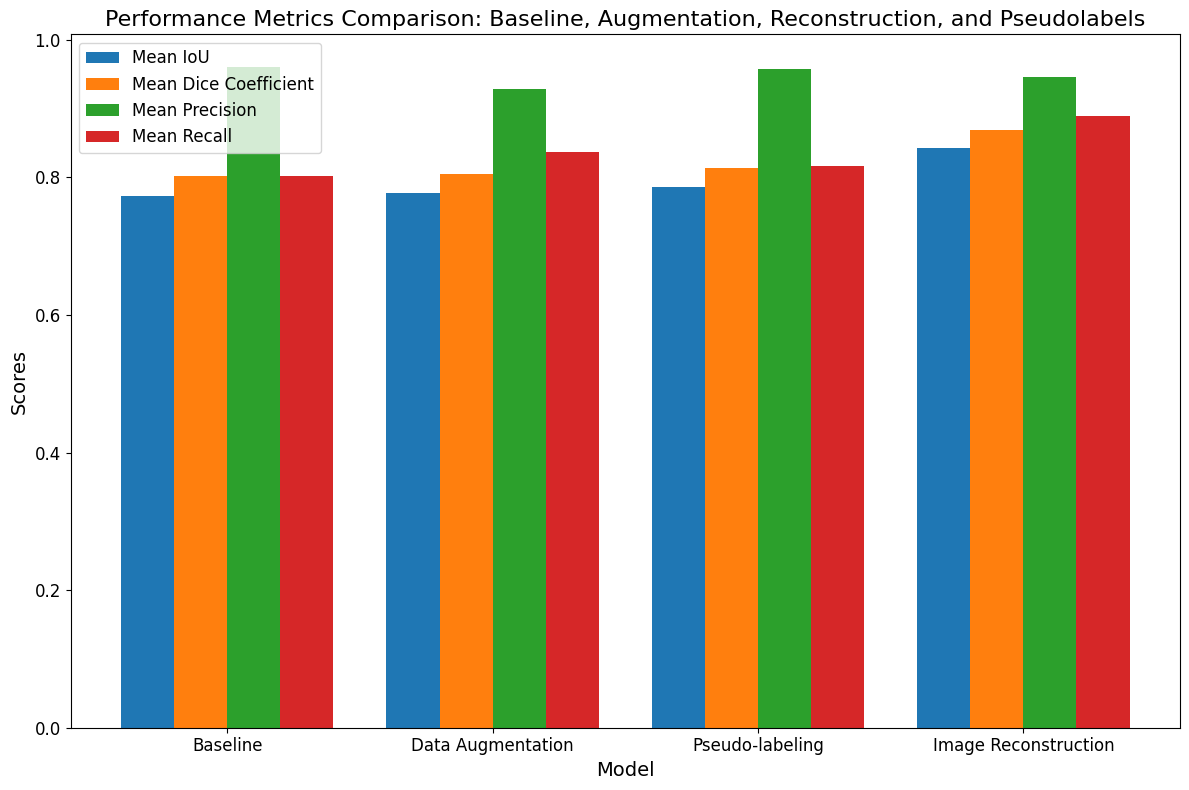

In [ ]:
# Filter the dataframe to include only the methods for the first comparison

comparison_df = prediction_df[prediction_df['Model'].isin(['Baseline', 'Data Augmentation',  'Pseudo-labeling', 'Image Reconstruction'])]

plt.figure(figsize=(12, 8))
x = range(len(comparison_df['Model']))
colors = {
    'Mean IoU': '#1f77b4',
    'Mean Dice Coefficient': '#ff7f0e',
    'Mean Precision': '#2ca02c',
    'Mean Recall': '#d62728'
}
plt.bar(x, comparison_df['Mean IoU'], width=0.2, label='Mean IoU', align='center', color=colors['Mean IoU'])
plt.bar([p + 0.2 for p in x], comparison_df['Mean Dice Coefficient'], width=0.2, label='Mean Dice Coefficient', align='center', color=colors['Mean Dice Coefficient'])
plt.bar([p + 0.4 for p in x], comparison_df['Mean Precision'], width=0.2, label='Mean Precision', align='center', color=colors['Mean Precision'])
plt.bar([p + 0.6 for p in x], comparison_df['Mean Recall'], width=0.2, label='Mean Recall', align='center', color=colors['Mean Recall'])

plt.xlabel('Model', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.title('Performance Metrics Comparison: Baseline, Augmentation, Reconstruction, and Pseudolabels', fontsize=16)
plt.xticks([p + 0.3 for p in x], comparison_df['Model'], fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig(ROOT + 'comparison_baseline_augmentation_reconstruction_pseudolabels.png')
plt.show()

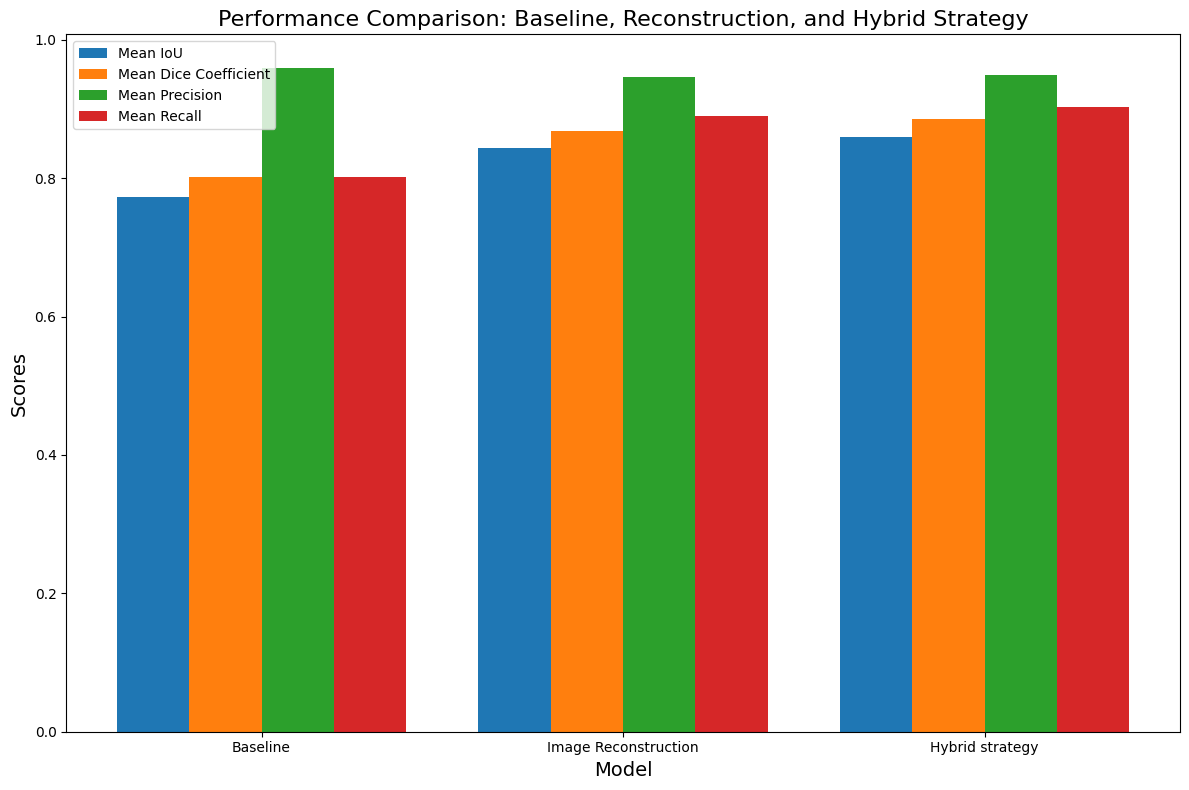

In [ ]:
comparison_df = prediction_df[prediction_df['Model'].isin(['Baseline',  'Image Reconstruction', 'Hybrid strategy'])]

plt.figure(figsize=(12, 8))
x = range(len(comparison_df['Model']))

plt.bar(x, comparison_df['Mean IoU'], width=0.2, label='Mean IoU', align='center', color=colors['Mean IoU'])
plt.bar([p + 0.2 for p in x], comparison_df['Mean Dice Coefficient'], width=0.2, label='Mean Dice Coefficient', align='center', color=colors['Mean Dice Coefficient'])
plt.bar([p + 0.4 for p in x], comparison_df['Mean Precision'], width=0.2, label='Mean Precision', align='center', color=colors['Mean Precision'])
plt.bar([p + 0.6 for p in x], comparison_df['Mean Recall'], width=0.2, label='Mean Recall', align='center', color=colors['Mean Recall'])

plt.xlabel('Model', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.title('Performance Comparison: Baseline, Reconstruction, and Hybrid Strategy', fontsize=16)
plt.xticks([p + 0.3 for p in x], comparison_df['Model'])
plt.legend()

plt.tight_layout()
plt.savefig(ROOT + 'comparison_reconstruction_mixstrategy.png')
plt.show()

In [ ]:
val_subset_df = val_df.iloc[:30]
images = np.array(list(map(lambda v: decode_and_resize_image(v).numpy(), val_subset_df['images_paths'])))
masks = np.array(list(map(lambda v: decode_and_resize_mask(v).numpy(), val_subset_df['masks_paths'])))

preds = model_1.predict(images)
pred_thresholded = tf.cast(preds > 0.5, dtype=tf.float32).numpy()

abnormal_masks = []

for i, (pred, mask) in enumerate(zip(pred_thresholded, masks)):
    if np.any(pred > 0):
        abnormal_masks.append(val_subset_df.iloc[i])

    if len(abnormal_masks) >= 3:
        break

abnormal_masks_df = pd.DataFrame(abnormal_masks)

<ipython-input-5-b7bfb1c12be3>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(IMAGE_SIZE, Image.ANTIALIAS)  # Resize the image


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [ ]:
normal_masks = []
for idx, row in val_subset_df.iterrows():
    mask_path = row['masks_paths']
    mask = np.array(Image.open(mask_path))
    if np.all(mask == 0):
        normal_masks.append(row)
        if len(normal_masks) == 3:
            break
normal_masks_df = pd.DataFrame(normal_masks)

<ipython-input-5-b7bfb1c12be3>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(IMAGE_SIZE, Image.ANTIALIAS)  # Resize the image


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


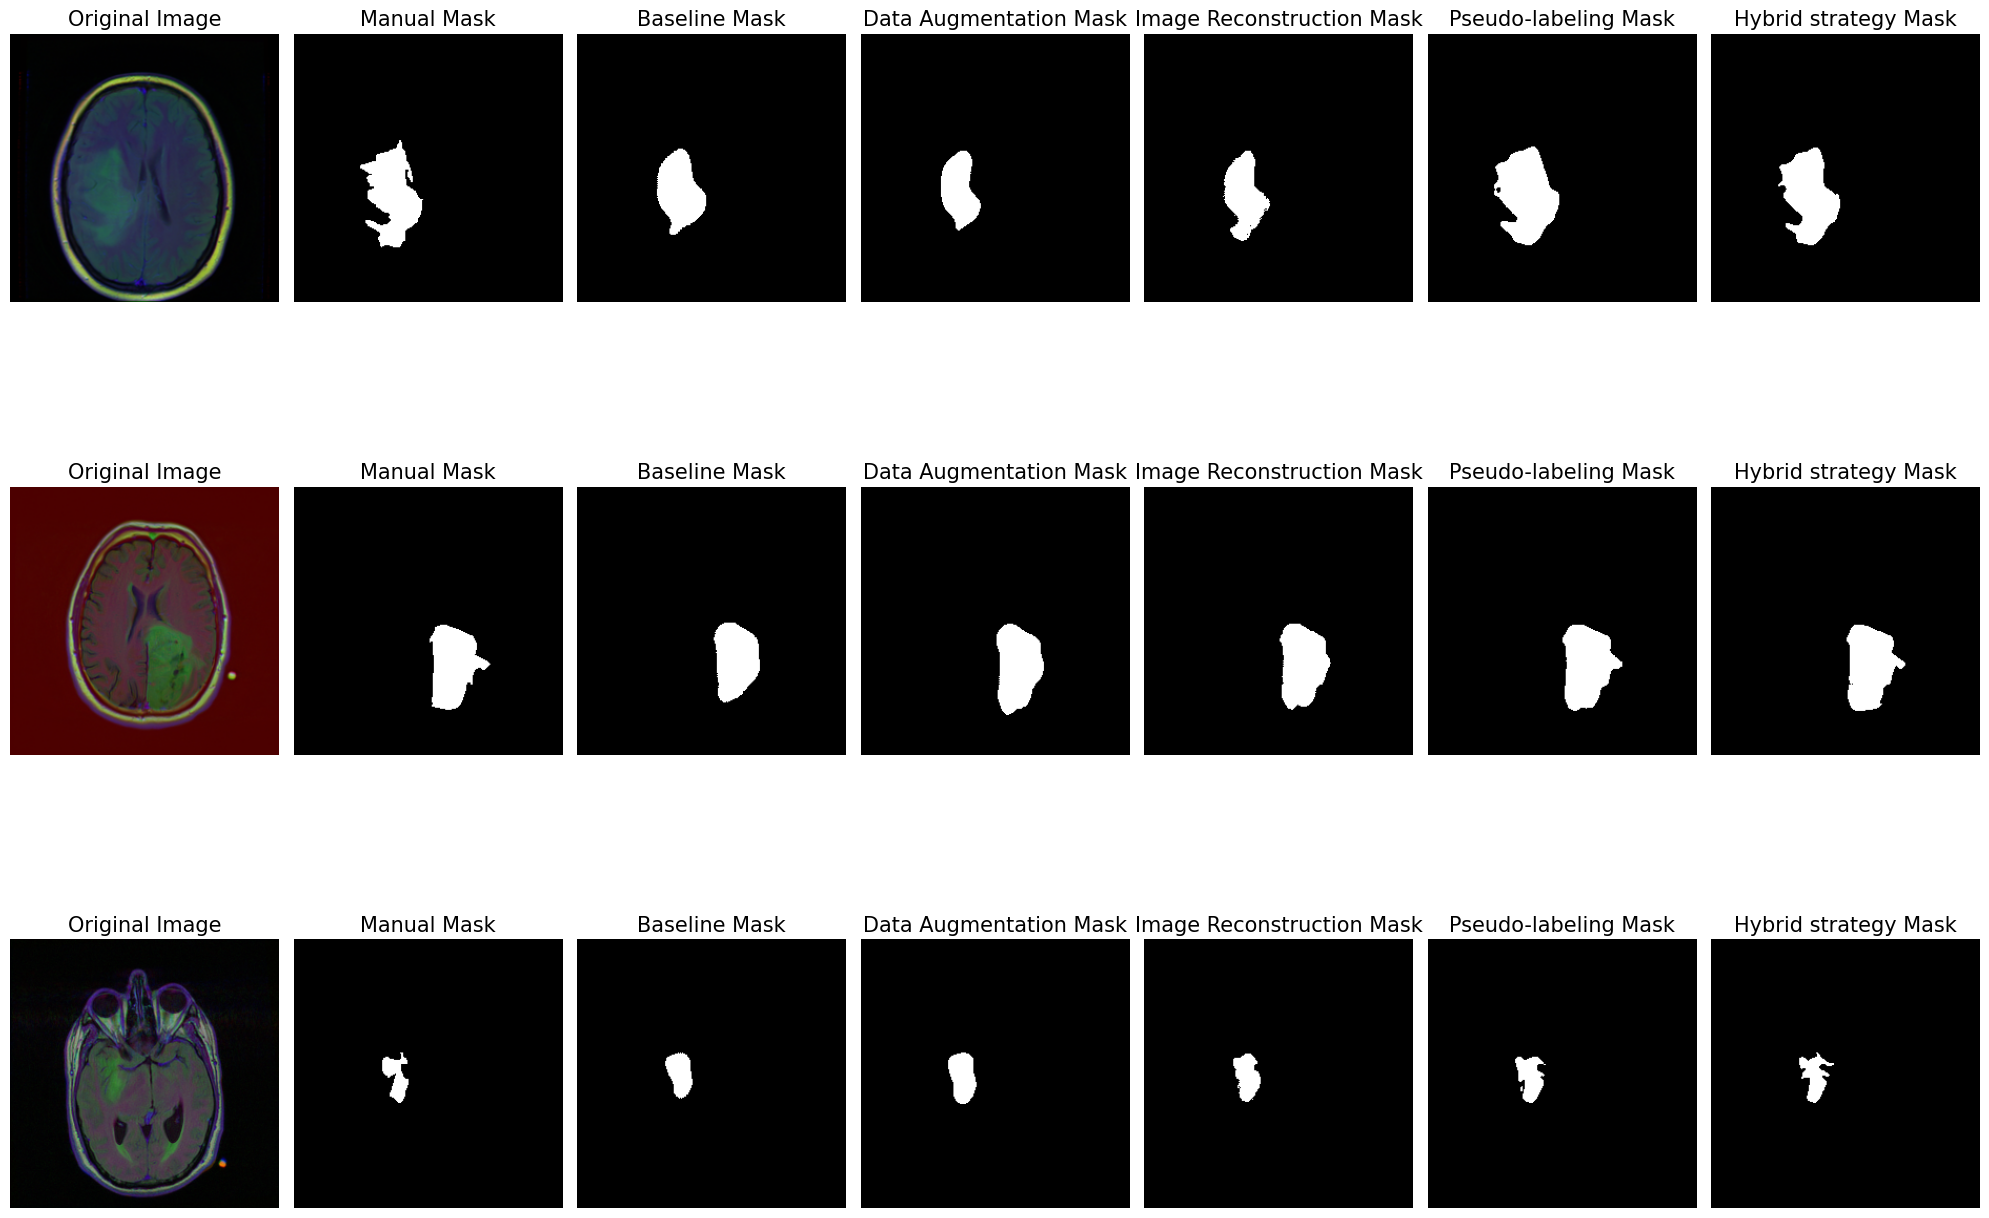

In [ ]:
def visualize_all_predictions(df, models, threshold=0.5, save_path=None):
    images = np.array(list(map(lambda v: decode_and_resize_image(v), df['images_paths'])))
    masks = np.array(list(map(lambda v: decode_and_resize_mask(v), df['masks_paths'])))

    fig, axes = plt.subplots(len(df), len(models) + 2, figsize=(20, len(df) * 5))

    for i in range(len(df)):
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title('Original Image', fontsize=15)
        axes[i, 1].imshow(masks[i], cmap='gray')
        axes[i, 1].set_title('Manual Mask', fontsize=15)

        for j, (model, model_name) in enumerate(models):
            preds = model.predict(images)
            pred_thresholded = tf.cast(preds > threshold, dtype=tf.float32).numpy()
            axes[i, j + 2].imshow(pred_thresholded[i].squeeze(), cmap='gray')
            axes[i, j + 2].set_title(f'{model_name} Mask', fontsize=15)

        for ax in axes[i]:
            ax.axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

visualize_all_predictions(abnormal_masks_df, models, save_path=ROOT + 'abnormal_masks_predictions.png')

<ipython-input-5-b7bfb1c12be3>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(IMAGE_SIZE, Image.ANTIALIAS)  # Resize the image


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


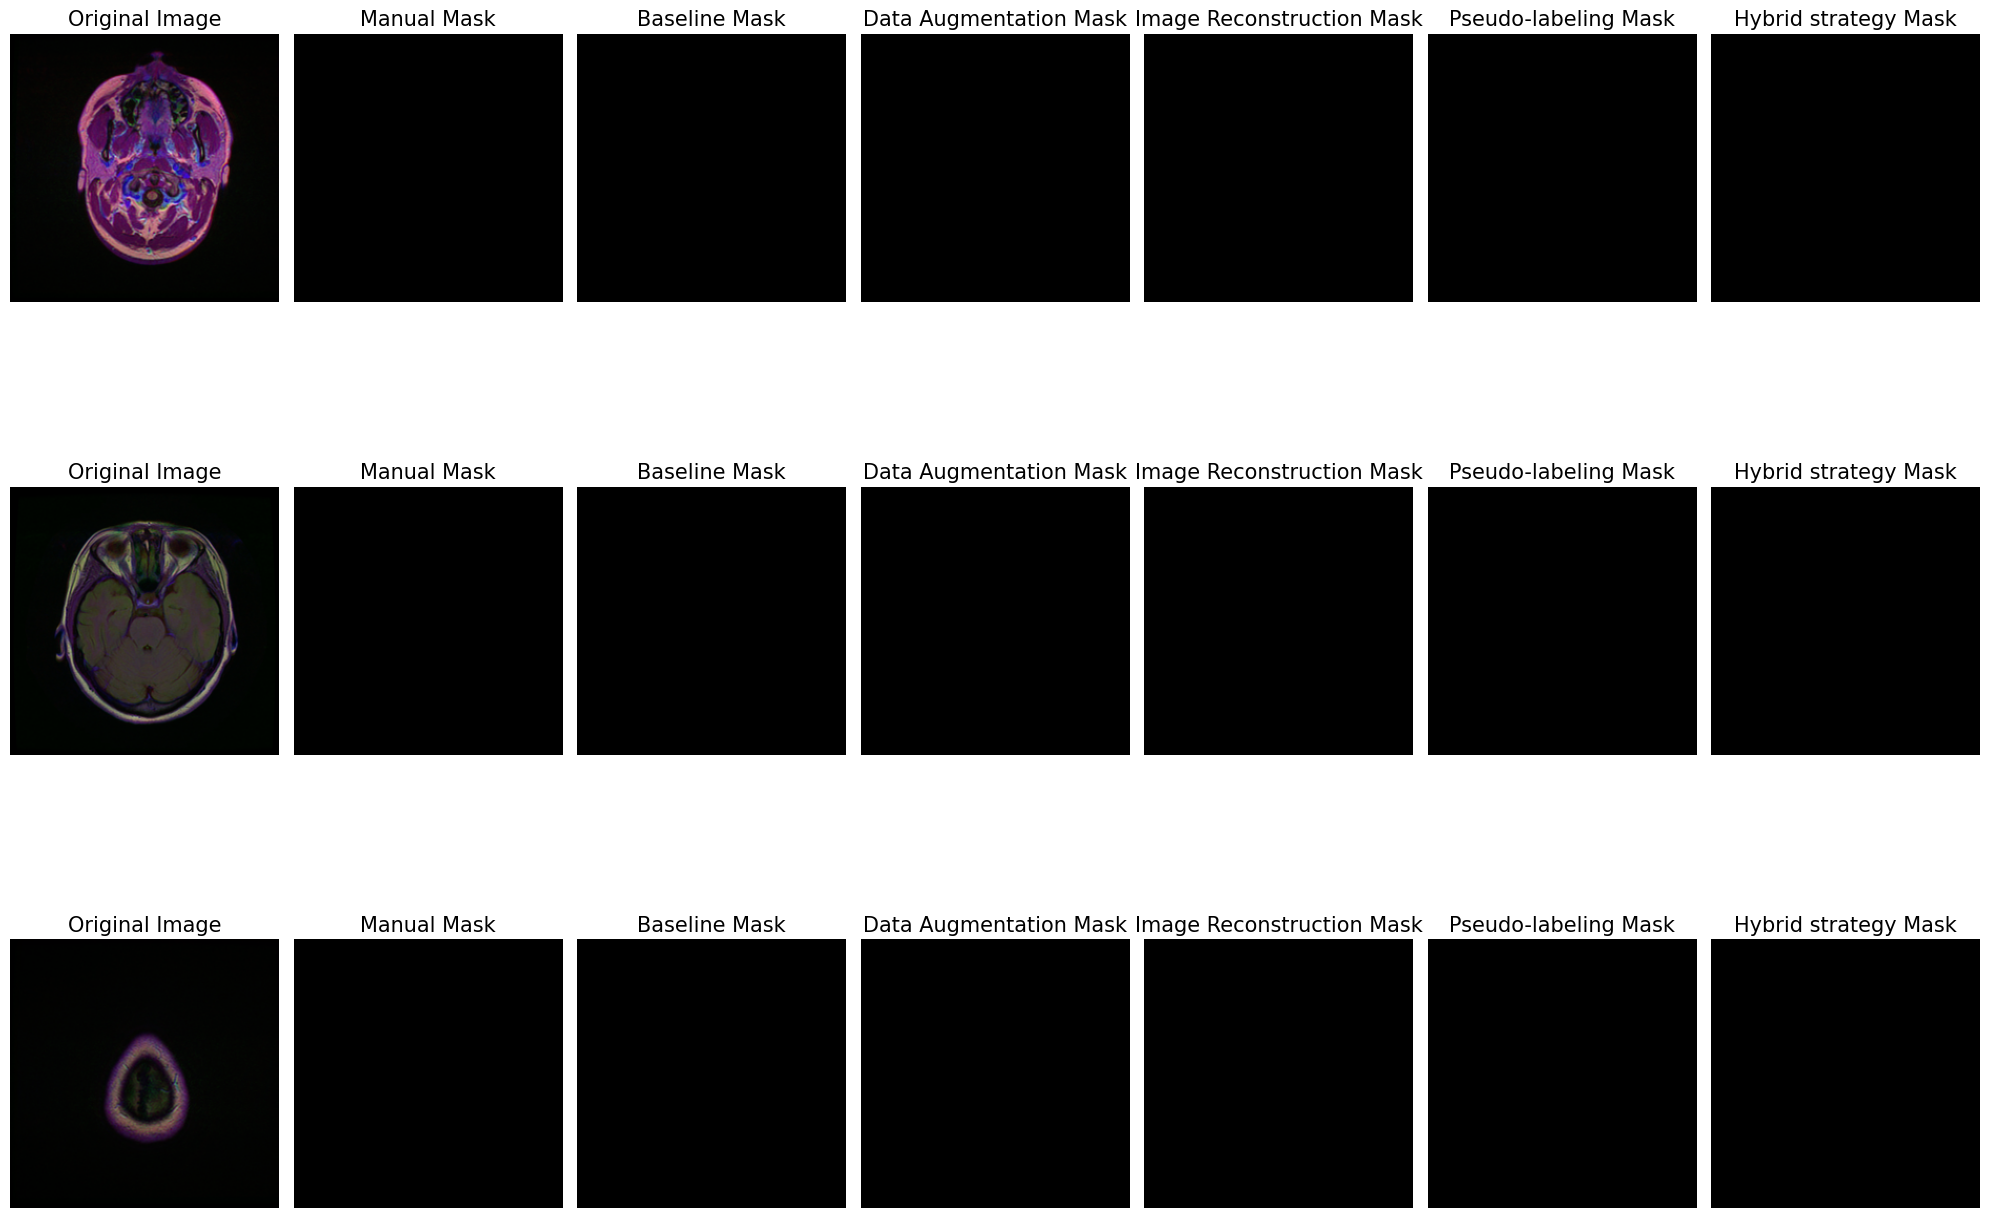

In [ ]:
visualize_all_predictions(normal_masks_df, models, save_path=ROOT + 'normal_masks_predictions.png')

In [ ]:
train_df, other_df = train_test_split(df, test_size=0.9, random_state=42)
unlabeled_df, val_df = train_test_split(other_df, test_size=0.1, random_state=42)

In [ ]:
images_paths = np.array(list(train_df['images_paths'].values))
masks_paths = np.array(list(train_df['masks_paths'].values))

In [ ]:
from sklearn.model_selection import KFold
def cross_validate_unet(make_dataset_, images_paths, masks_paths, num_folds=5, epochs=20, verbose=1):
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    fold_no = 1
    results = []

    for train_idx, val_idx in kfold.split(images_paths):

        train_images = images_paths[train_idx]
        train_masks = masks_paths[train_idx]
        val_images = images_paths[val_idx]
        val_masks = masks_paths[val_idx]

        train_dataset = make_dataset_(train_images, train_masks)
        validation_dataset = make_dataset(val_images, val_masks)

        model = unet()

        early_stopping = EarlyStopping(monitor='val_loss',
                        patience=12,
                        restore_best_weights=True)

        history = model.fit(train_dataset,
                  validation_data=validation_dataset,
                  epochs=epochs,
                  callbacks=[early_stopping],
                  verbose=verbose)

        model.set_weights(early_stopping.best_weights)


        val_images_resized = np.array([decode_and_resize_image(path) for path in val_images])
        val_masks_resized = np.array([decode_and_resize_mask(path) for path in val_masks])

        pred = model.predict(val_images_resized)
        pred_thresholded = tf.cast(pred > 0.5, dtype=tf.float32)

        iou = np.mean(IoU(val_masks_resized, pred_thresholded))
        dice = np.mean(DiceCoefficient(val_masks_resized, pred_thresholded))
        precision = np.mean(Precision(val_masks_resized, pred_thresholded))
        recall = np.mean(Recall(val_masks_resized, pred_thresholded))

        results.append({
            'Fold': fold_no,
            'IoU': round(iou, 3),
            'Dice': round(dice, 3),
            'Precision': round(precision, 3),
            'Recall': round(recall, 3)
        })

        fold_no += 1

    return results

In [ ]:
results_1 = cross_validate_unet(make_dataset, images_paths, masks_paths, num_folds=5, epochs=40, verbose=1)

<ipython-input-5-b7bfb1c12be3>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(IMAGE_SIZE, Image.ANTIALIAS)  # Resize the image
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/40
10/10 [==============================] - 13s 518ms/step - loss: 0.1250 - val_loss: 0.2098
Epoch 2/40
10/10 [==============================] - 5s 474ms/step - loss: 0.0800 - val_loss: 0.1751
Epoch 3/40
10/10 [==============================] - 5s 478ms/step - loss: 0.0627 - val_loss: 0.1654
Epoch 4/40
10/10 [==============================] - 5s 479ms/step - loss: 0.0494 - val_loss: 0.1401
Epoch 5/40
10/10 [==============================] - 5s 480ms/step - loss: 0.0417 - val_loss: 0.1227
Epoch 6/40
10/10 [==============================] - 5s 479ms/step - loss: 0.0346 - val_loss: 0.1030
Epoch 7/40
10/10 [==============================] - 5s 475ms/step - loss: 0.0313 - val_loss: 0.0913
Epoch 8/40
10/10 [==============================] - 5s 471ms/step - loss: 0.0282 - val_loss: 0.0800
Epoch 9/40
10/10 [==============================] - 5s 471ms/step - loss: 0.0240 - val_loss: 0.0657
Epoch 10/40
10/10 [==============================] - 5s 467ms/step - loss: 0.0227 - val_loss: 0.069

In [ ]:
results_1 = pd.DataFrame(results_1)
results_1

,Fold,IoU,Dice,Precision,Recall
0,1,0.767,0.781,0.962,0.802
1,2,0.734,0.762,0.993,0.735
2,3,0.796,0.821,0.968,0.819
3,4,0.739,0.767,0.926,0.789
4,5,0.663,0.706,0.863,0.781


In [ ]:
results_2 = cross_validate_unet(make_dataset_augmentation, images_paths, masks_paths, num_folds=5, epochs=40, verbose=1)

<ipython-input-5-b7bfb1c12be3>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(IMAGE_SIZE, Image.ANTIALIAS)  # Resize the image
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/40
10/10 [==============================] - 14s 514ms/step - loss: 0.1603 - val_loss: 0.3125
Epoch 2/40
10/10 [==============================] - 6s 473ms/step - loss: 0.1118 - val_loss: 0.3418
Epoch 3/40
10/10 [==============================] - 6s 475ms/step - loss: 0.0829 - val_loss: 0.4392
Epoch 4/40
10/10 [==============================] - 6s 484ms/step - loss: 0.0657 - val_loss: 0.2958
Epoch 5/40
10/10 [==============================] - 6s 476ms/step - loss: 0.0562 - val_loss: 0.4658
Epoch 6/40
10/10 [==============================] - 6s 481ms/step - loss: 0.0510 - val_loss: 0.5990
Epoch 7/40
10/10 [==============================] - 6s 479ms/step - loss: 0.0474 - val_loss: 0.5387
Epoch 8/40
10/10 [==============================] - 6s 483ms/step - loss: 0.0422 - val_loss: 0.3604
Epoch 9/40
10/10 [==============================] - 6s 474ms/step - loss: 0.0416 - val_loss: 0.3172
Epoch 10/40
10/10 [==============================] - 6s 474ms/step - loss: 0.0410 - val_loss: 0.213

In [ ]:
results_2 = pd.DataFrame(results_2)
results_2

,Fold,IoU,Dice,Precision,Recall
0,1,0.765,0.782,0.947,0.814
1,2,0.743,0.775,0.971,0.755
2,3,0.740,0.764,0.929,0.805
3,4,0.800,0.831,0.898,0.878
4,5,0.654,0.692,0.893,0.752


In [ ]:
def cross_validate_predictions(df, model, top_percent_1=0.02, top_percent_0=0.06, threshold=0.5):
    x = np.array(list(map(lambda v: decode_and_resize_image(v), df['images_paths'])))

    # Predicting the masks
    pred = model.predict(x)

    high_quality_predictions_1 = []
    high_quality_predictions_0 = []

    for i in range(len(df)):
        pred_mask = tf.cast(pred[i] > threshold, dtype=tf.float32)

        between_thresholds = tf.reduce_mean(tf.cast(tf.logical_and(pred[i] > 0.2, pred[i] < 0.8), tf.float32))
        prediction = {
            'image_path': df['images_paths'].values[i],
            'predicted_mask': pred_mask.numpy(),
            'between_thresholds': between_thresholds.numpy()
        }

        if np.max(pred_mask.numpy()) > 0:
            high_quality_predictions_1.append(prediction)
        else:
            high_quality_predictions_0.append(prediction)

    # Sort predictions by the proportion between thresholds (ascending order)
    high_quality_predictions_1.sort(key=lambda x: x['between_thresholds'])
    high_quality_predictions_0.sort(key=lambda x: x['between_thresholds'])

    # Calculate the number of predictions to keep for each group
    num_high = int((len(df)) * top_percent_1)
    num_low = int((len(df)) * top_percent_0)

    # Select top predictions for high_quality_predictions and high_quality_predictions_1
    high_predictions_1 = high_quality_predictions_1[:num_high]
    high_predictions_0 = high_quality_predictions_0[:num_low]
    high_quality_predictions = high_predictions_1 + high_predictions_0


    return high_quality_predictions

In [ ]:
def cross_validate_unet_Pseudolabels(model, image_paths, mask_path, make_dataset_, images_paths, masks_paths, num_folds=5, epochs=20, verbose=1):
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    fold_no = 1
    results = []

    for train_idx, val_idx in kfold.split(images_paths):
        train_images = images_paths[train_idx]
        train_masks = masks_paths[train_idx]
        val_images = images_paths[val_idx]
        val_masks = masks_paths[val_idx]

        train_dataset = make_dataset_((image_paths+train_images.tolist()), (mask_path+train_masks.tolist()))

        validation_dataset = make_dataset(val_images, val_masks)

        early_stopping = EarlyStopping(monitor='val_loss',
                        patience=12,
                        restore_best_weights=True)

        history = model.fit(train_dataset,
                  validation_data=validation_dataset,
                  epochs=epochs,
                  callbacks=[early_stopping],
                  verbose=verbose)

        model.set_weights(early_stopping.best_weights)



        val_images_resized = np.array([decode_and_resize_image(path) for path in val_images])
        val_masks_resized = np.array([decode_and_resize_mask(path) for path in val_masks])

        pred = model.predict(val_images_resized)
        pred_thresholded = tf.cast(pred > 0.5, dtype=tf.float32)

        iou = np.mean(IoU(val_masks_resized, pred_thresholded))
        dice = np.mean(DiceCoefficient(val_masks_resized, pred_thresholded))
        precision = np.mean(Precision(val_masks_resized, pred_thresholded))
        recall = np.mean(Recall(val_masks_resized, pred_thresholded))

        results.append({
            'Fold': fold_no,
            'IoU': round(iou, 3),
            'Dice': round(dice, 3),
            'Precision': round(precision, 3),
            'Recall': round(recall, 3)
        })

        fold_no += 1

    return results

In [ ]:
model = unet()
model.load_weights(ROOT + "archive/best_model_no_augmentation.h5")
save_dir = ROOT + "archive/PseudoLabels"
high_quality_predictions = cross_validate_predictions(unlabeled_df, model)
save_predictions(high_quality_predictions, save_dir)

image_paths = []
mask_paths = []
for pred in high_quality_predictions:
    image_path = pred['image_path']
    mask_path = os.path.join(save_dir, os.path.basename(image_path).replace('.tif', '_mask.tif'))
    image_paths.append(image_path)
    mask_paths.append(mask_path)


<ipython-input-5-b7bfb1c12be3>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(IMAGE_SIZE, Image.ANTIALIAS)  # Resize the image


100/100 [==============================] - 14s 133ms/step


In [ ]:
results_3 = cross_validate_unet_Pseudolabels(model, image_paths, mask_paths, make_dataset, images_paths, masks_paths, num_folds=5, epochs=40, verbose=1)
results_3 = pd.DataFrame(results_3)
results_3

<ipython-input-5-b7bfb1c12be3>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(IMAGE_SIZE, Image.ANTIALIAS)  # Resize the image


Epoch 1/40
18/18 [==============================] - 33s 1s/step - loss: 0.0102 - val_loss: 0.0181
Epoch 2/40
18/18 [==============================] - 8s 451ms/step - loss: 0.0081 - val_loss: 0.0127
Epoch 3/40
18/18 [==============================] - 8s 451ms/step - loss: 0.0073 - val_loss: 0.0103
Epoch 4/40
18/18 [==============================] - 8s 446ms/step - loss: 0.0069 - val_loss: 0.0107
Epoch 5/40
18/18 [==============================] - 8s 444ms/step - loss: 0.0072 - val_loss: 0.0113
Epoch 6/40
18/18 [==============================] - 8s 446ms/step - loss: 0.0061 - val_loss: 0.0093
Epoch 7/40
18/18 [==============================] - 8s 446ms/step - loss: 0.0056 - val_loss: 0.0094
Epoch 8/40
18/18 [==============================] - 8s 450ms/step - loss: 0.0048 - val_loss: 0.0064
Epoch 9/40
18/18 [==============================] - 8s 450ms/step - loss: 0.0041 - val_loss: 0.0072
Epoch 10/40
18/18 [==============================] - 8s 451ms/step - loss: 0.0043 - val_loss: 0.0208
E

In [ ]:
results_3

,Fold,IoU,Dice,Precision,Recall
0,1,0.842,0.867,0.958,0.866
1,2,0.841,0.868,0.967,0.866
2,3,0.826,0.846,0.963,0.857
3,4,0.811,0.839,0.899,0.882
4,5,0.776,0.814,0.957,0.811


In [ ]:
data_dir = ROOT + 'archive/recon_folder'
images_paths = []
masks_paths = glob(f'{data_dir}/*_mask*')

for mask_path in masks_paths:
    image_path = mask_path.replace('_mask', '')
    images_paths.append(image_path)

recon_df = pd.DataFrame(data={'images_paths': images_paths, 'masks_paths': masks_paths})

In [ ]:
def cross_validate_unet_recon(make_dataset_, recon_df, images_paths, masks_paths, num_folds=5, epochs=20, verbose=1):
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    fold_no = 1
    results = []

    for train_idx, val_idx in kfold.split(images_paths):

        train_images = images_paths[train_idx]
        train_masks = masks_paths[train_idx]
        val_images = images_paths[val_idx]
        val_masks = masks_paths[val_idx]
        recon_images = np.array(list(recon_df['images_paths'].values))
        recon_masks = np.array(list(recon_df['masks_paths'].values))

        train_dataset = make_dataset_(train_images.tolist()+recon_images.tolist(), train_masks.tolist()+recon_masks.tolist())
        validation_dataset = make_dataset(val_images, val_masks)

        model = unet()

        early_stopping = EarlyStopping(monitor='val_loss',
                        patience=12,
                        restore_best_weights=True)

        history = model.fit(train_dataset,
                  validation_data=validation_dataset,
                  epochs=epochs,
                  callbacks=[early_stopping],
                  verbose=verbose)

        model.set_weights(early_stopping.best_weights)


        val_images_resized = np.array([decode_and_resize_image(path) for path in val_images])
        val_masks_resized = np.array([decode_and_resize_mask(path) for path in val_masks])

        pred = model.predict(val_images_resized)
        pred_thresholded = tf.cast(pred > 0.5, dtype=tf.float32)

        iou = np.mean(IoU(val_masks_resized, pred_thresholded))
        dice = np.mean(DiceCoefficient(val_masks_resized, pred_thresholded))
        precision = np.mean(Precision(val_masks_resized, pred_thresholded))
        recall = np.mean(Recall(val_masks_resized, pred_thresholded))

        results.append({
            'Fold': fold_no,
            'IoU': round(iou, 3),
            'Dice': round(dice, 3),
            'Precision': round(precision, 3),
            'Recall': round(recall, 3)
        })

        fold_no += 1

    return results

In [ ]:
results_4 = cross_validate_unet_recon(make_dataset, recon_df, images_paths, masks_paths, num_folds=5, epochs=40, verbose=1)

<ipython-input-5-b7bfb1c12be3>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(IMAGE_SIZE, Image.ANTIALIAS)  # Resize the image
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/40
47/47 [==============================] - 44s 763ms/step - loss: 0.1189 - val_loss: 0.8054
Epoch 2/40
47/47 [==============================] - 21s 438ms/step - loss: 0.0534 - val_loss: 0.1518
Epoch 3/40
47/47 [==============================] - 21s 437ms/step - loss: 0.0428 - val_loss: 0.0735
Epoch 4/40
47/47 [==============================] - 21s 443ms/step - loss: 0.0372 - val_loss: 0.0667
Epoch 5/40
47/47 [==============================] - 21s 444ms/step - loss: 0.0313 - val_loss: 0.0337
Epoch 6/40
47/47 [==============================] - 21s 443ms/step - loss: 0.0286 - val_loss: 0.0275
Epoch 7/40
47/47 [==============================] - 21s 441ms/step - loss: 0.0253 - val_loss: 0.0220
Epoch 8/40
47/47 [==============================] - 21s 440ms/step - loss: 0.0239 - val_loss: 0.0239
Epoch 9/40
47/47 [==============================] - 21s 442ms/step - loss: 0.0230 - val_loss: 0.0155
Epoch 10/40
47/47 [==============================] - 21s 443ms/step - loss: 0.0206 - val_lo

In [ ]:
results_4 = pd.DataFrame(results_4)
results_4

,Fold,IoU,Dice,Precision,Recall
0,1,0.786,0.813,0.892,0.887
1,2,0.752,0.783,0.887,0.858
2,3,0.823,0.850,0.954,0.862
3,4,0.878,0.904,0.907,0.963
4,5,0.799,0.836,0.916,0.872


In [ ]:
model = unet()
model.load_weights(ROOT + "archive/best_model_with_reconstruction.h5")
save_dir = ROOT + "archive/PseudoLabels"
high_quality_predictions = cross_validate_predictions(unlabeled_df, model)
save_predictions(high_quality_predictions, save_dir)

image_paths = []
mask_paths = []
for pred in high_quality_predictions:
    image_path = pred['image_path']
    mask_path = os.path.join(save_dir, os.path.basename(image_path).replace('.tif', '_mask.tif'))
    image_paths.append(image_path)
    mask_paths.append(mask_path)

<ipython-input-5-b7bfb1c12be3>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(IMAGE_SIZE, Image.ANTIALIAS)  # Resize the image


100/100 [==============================] - 14s 132ms/step


In [ ]:
def cross_validate_unet_mix(model, recon_df, image_paths, mask_path, make_dataset_, images_paths, masks_paths, num_folds=5, epochs=20, verbose=1):
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    fold_no = 1
    results = []

    for train_idx, val_idx in kfold.split(images_paths):
        train_images = images_paths[train_idx]
        train_masks = masks_paths[train_idx]
        val_images = images_paths[val_idx]
        val_masks = masks_paths[val_idx]

        recon_images = np.array(list(recon_df['images_paths'].values))
        recon_masks = np.array(list(recon_df['masks_paths'].values))

        train_dataset = make_dataset_((image_paths+train_images.tolist()+recon_images.tolist()), (mask_path+train_masks.tolist()+recon_masks.tolist()))

        validation_dataset = make_dataset(val_images, val_masks)

        early_stopping = EarlyStopping(monitor='val_loss',
                        patience=12,
                        restore_best_weights=True)

        history = model.fit(train_dataset,
                  validation_data=validation_dataset,
                  epochs=epochs,
                  callbacks=[early_stopping],
                  verbose=verbose)

        model.set_weights(early_stopping.best_weights)



        val_images_resized = np.array([decode_and_resize_image(path) for path in val_images])
        val_masks_resized = np.array([decode_and_resize_mask(path) for path in val_masks])

        pred = model.predict(val_images_resized)
        pred_thresholded = tf.cast(pred > 0.5, dtype=tf.float32)

        iou = np.mean(IoU(val_masks_resized, pred_thresholded))
        dice = np.mean(DiceCoefficient(val_masks_resized, pred_thresholded))
        precision = np.mean(Precision(val_masks_resized, pred_thresholded))
        recall = np.mean(Recall(val_masks_resized, pred_thresholded))

        results.append({
            'Fold': fold_no,
            'IoU': round(iou, 3),
            'Dice': round(dice, 3),
            'Precision': round(precision, 3),
            'Recall': round(recall, 3)
        })

        fold_no += 1

    return results

In [ ]:
results_5 = cross_validate_unet_mix(model, recon_df, image_paths, mask_paths, make_dataset_augmentation, images_paths, masks_paths, num_folds=5, epochs=40, verbose=1)
results_5 = pd.DataFrame(results_5)
results_5

<ipython-input-5-b7bfb1c12be3>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(IMAGE_SIZE, Image.ANTIALIAS)  # Resize the image


Epoch 1/40
55/55 [==============================] - 45s 659ms/step - loss: 0.0060 - val_loss: 0.0029
Epoch 2/40
55/55 [==============================] - 30s 521ms/step - loss: 0.0054 - val_loss: 0.0029
Epoch 3/40
55/55 [==============================] - 30s 524ms/step - loss: 0.0048 - val_loss: 0.0026
Epoch 4/40
55/55 [==============================] - 30s 526ms/step - loss: 0.0052 - val_loss: 0.0034
Epoch 5/40
55/55 [==============================] - 30s 521ms/step - loss: 0.0053 - val_loss: 0.0032
Epoch 6/40
55/55 [==============================] - 30s 523ms/step - loss: 0.0058 - val_loss: 0.0032
Epoch 7/40
55/55 [==============================] - 30s 530ms/step - loss: 0.0047 - val_loss: 0.0033
Epoch 8/40
55/55 [==============================] - 30s 523ms/step - loss: 0.0045 - val_loss: 0.0027
Epoch 9/40
55/55 [==============================] - 30s 524ms/step - loss: 0.0046 - val_loss: 0.0026
Epoch 10/40
55/55 [==============================] - 30s 524ms/step - loss: 0.0047 - val_lo

,Fold,IoU,Dice,Precision,Recall
0,1,0.803,0.828,0.876,0.922
1,2,0.875,0.907,0.948,0.920
2,3,0.856,0.880,0.958,0.891
3,4,0.929,0.955,0.961,0.963
4,5,0.835,0.869,0.927,0.900


In [ ]:
mean_results_1 = results_1[['IoU', 'Dice', 'Precision', 'Recall']].mean()
mean_results_2 = results_2[['IoU', 'Dice', 'Precision', 'Recall']].mean()
mean_results_3 = results_3[['IoU', 'Dice', 'Precision', 'Recall']].mean()
mean_results_4 = results_4[['IoU', 'Dice', 'Precision', 'Recall']].mean()
mean_results_5 = results_5[['IoU', 'Dice', 'Precision', 'Recall']].mean()

mean_results = pd.DataFrame({
    'Metric': ['IoU', 'Dice', 'Precision', 'Recall'],
    'Baseline': mean_results_1.values,
    'With Augmentation': mean_results_2.values,
    'With Reconstruction': mean_results_3.values,
    'With Pseudolabels': mean_results_4.values,
    'Mix Strategy': mean_results_5.values
})

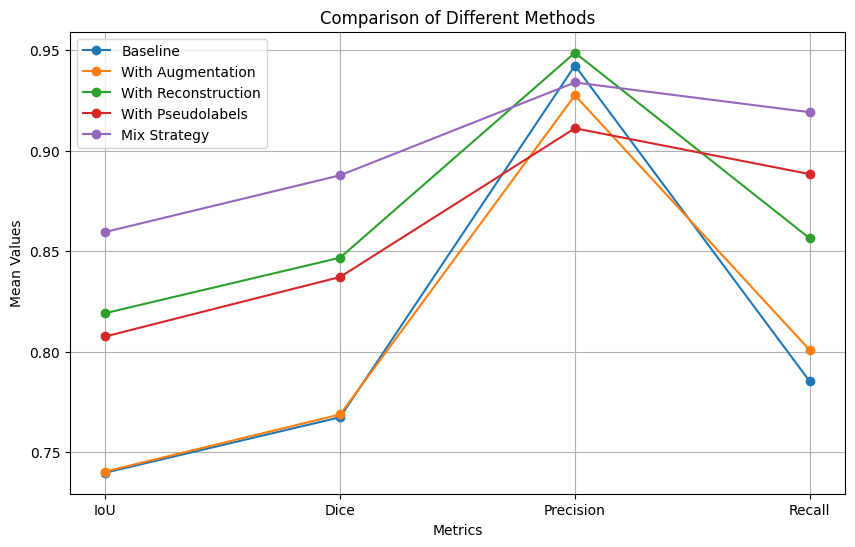

In [ ]:
plt.figure(figsize=(10, 6))
for column in mean_results.columns[1:]:
    plt.plot(mean_results['Metric'], mean_results[column], marker='o', label=column)

plt.xlabel('Metrics')
plt.ylabel('Mean Values')
plt.title('Comparison of Different Methods')
plt.legend()
plt.grid(True)

plt.savefig(ROOT+'comparison_of_methods.png')
plt.show()